# Trapezoidal extraction compare to box

## Imports

In [1]:
# Imports for plots

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm #for better display of FITS images

%matplotlib notebook

plt.rc('figure', figsize=(9,3))
plt.rcParams["image.cmap"] = "inferno"

# Imports froom standard packages

from scipy.interpolate import interp1d
from scipy.sparse import identity
from astropy.io import fits
import numpy as np

# Imports for extraction

from extract.overlap import TrpzOverlap
from extract.utils import grid_from_map

# Local imports
from simulation_utils import load_simu, add_noise

## Load ref files

In [2]:
DEFAULT_PATH = '../jwst-mtl/SOSS/extract/'
DEFAULT_REF_FILES = {'wv_1': 'Ref_files/wavelengths_m1.fits',
                     'wv_2': 'Ref_files/wavelengths_m2.fits',
                     'P_1': 'Ref_files/spat_profile_m1.fits',
                     'P_2': 'Ref_files/spat_profile_m2.fits'}

# Read relevant files
wv_1 = fits.open(DEFAULT_PATH + DEFAULT_REF_FILES["wv_1"])[0].data
wv_2 = fits.open(DEFAULT_PATH + DEFAULT_REF_FILES["wv_2"])[0].data
P1 = fits.open(DEFAULT_PATH + DEFAULT_REF_FILES["P_1"])[0].data.squeeze()
P2 = fits.open(DEFAULT_PATH + DEFAULT_REF_FILES["P_2"])[0].data.squeeze()

# Convert to float (fits precision is 1e-8)
wv_1 = wv_1.astype(float)
wv_2 = wv_2.astype(float)
P1 = P1.astype(float)
P2 = P2.astype(float)

# Remove the tilt from wv maps
wv_1 = np.tile(wv_1[50,:], (256, 1))
wv_2 = np.tile(wv_2[50,:], (256, 1))

## Load simu

In [3]:
# Load a simulation
simu = load_simu("../Simulations/phoenix_teff_02300_scale_1.0e+01_no-tilt.fits", order=1)
scidata = simu["data"]

## Box extraction

In [4]:
def box_extract(box_mask, data, lam_col):

    data_ma = np.ma.array(data, mask=box_mask)
    out = data_ma.sum(axis=0)
    
    i_sort = np.argsort(lam_col)
    
    return lam_col[i_sort], out[i_sort]

In [5]:
box_psf = (P1 > 1e-5)
grid_box, val_box = box_extract(~box_psf, scidata, wv_1[50,:])

<IPython.core.display.Javascript object>


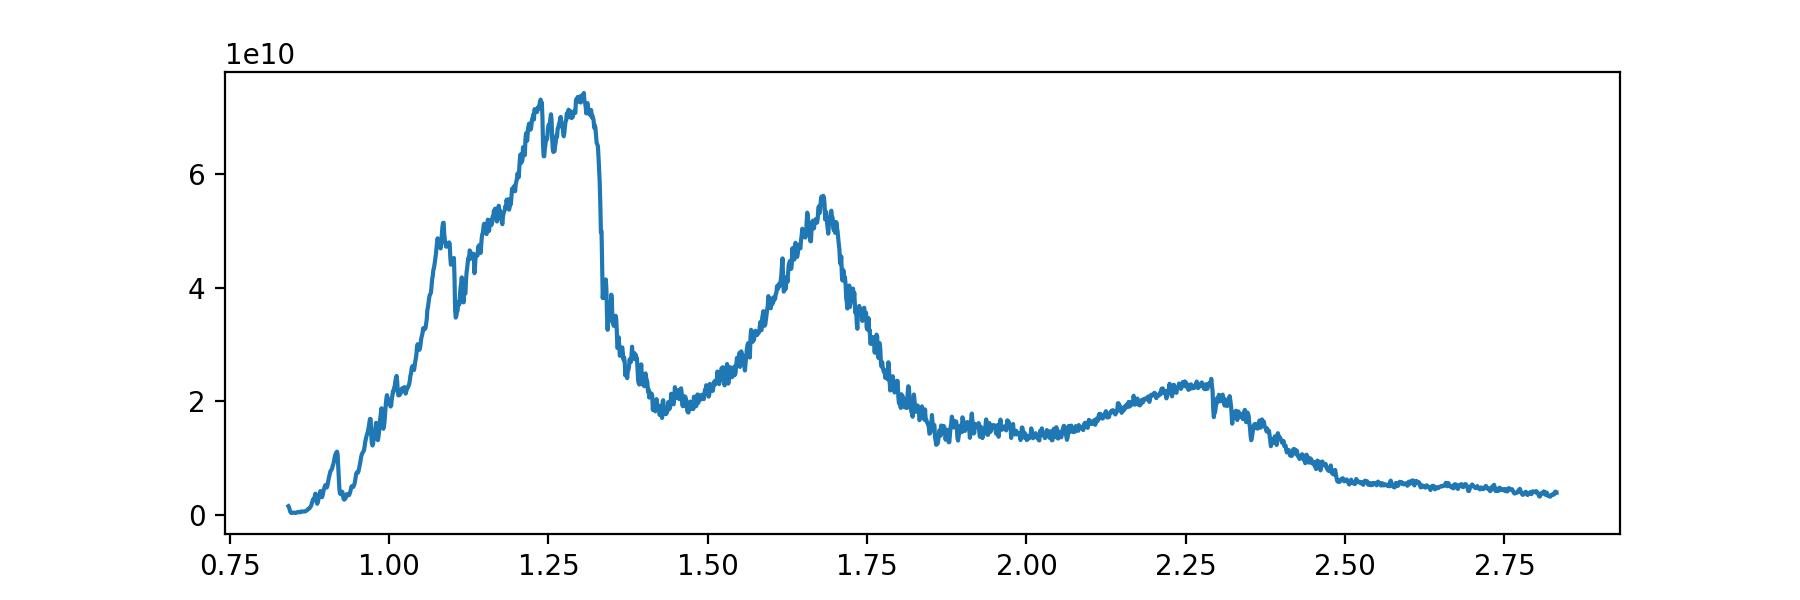

In [6]:
plt.plot(grid_box, val_box)

## Trpz extraction

In [26]:
np.array([True, False]).dtype == bool

True

<IPython.core.display.Javascript object>


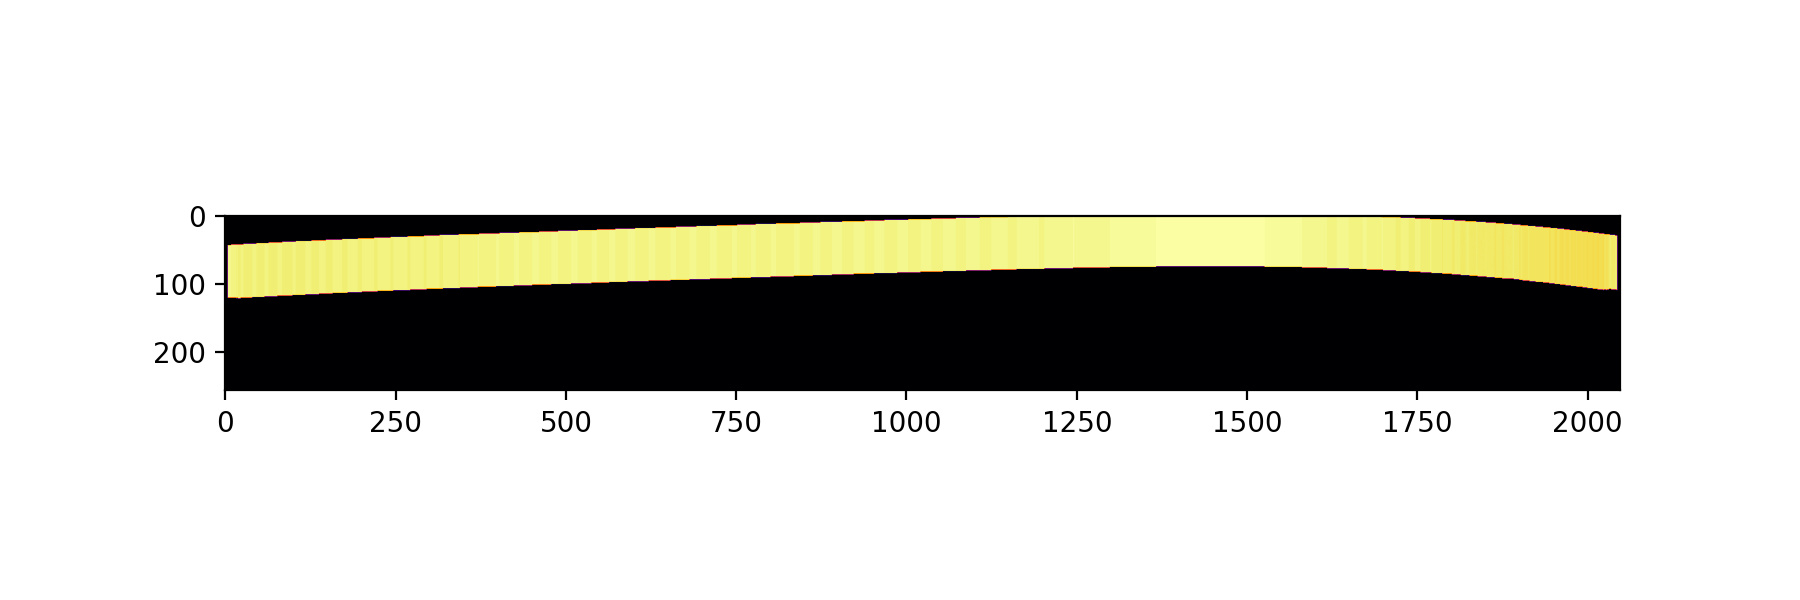

In [28]:
box_psf = (P1 > 1e-5)
box_psf = box_psf.astype(float)
norm = box_psf.sum(axis=0)
plt.imshow(np.divide(box_psf, norm, out=np.zeros_like(box_psf), where=norm!=0))

In [61]:
def fct_ones(x): 
    return np.ones_like(x)

class TrpzBox(TrpzOverlap):
    """
    Extraction class for simple box-like extraction.
    Useful to perform a box extraction and account
    for a tilt in the wavelength solution. If there
    is no tilt, the result is sensibly the same as
    a box extraction.
    """
    def __init__(self, aperture, wv_map, lam_grid=None,
                 thresh=1e-5, order=1, **kwargs):
        """
        Setup for extraction

        Parameters:
        -----------
        aperture: 2d-array, bool or float
            2d map of the trace aperture on the detector.
            If the data type is not boolean, the `thresh`
            kwarg is use to convert to boolean.
            aperture -> (aperture > thresh)
        wv_map: 2d-array
            wavelength map of the detector.
        lam_grid: 1d-array, optional
            grid use to do the trapezoidal extraction. Should
            be sampled at the native sampling of the detector.
            Default is to take the central wavelength for the pixel
            at the center of the trace for each column
        thresh: float, optional
            Threshold applied on `aperture` to convert to bool.
        order: int, optional
            Which order is extracted. Default is 1. Note that this
            argument has no effect on the result. It is only useful
            for the user as a way to identify the object.
        kwargs:
            the use of other kwargs is NOT recommended, but is available.
            They will be passed to `TrpzOverlap` during initiation.
        """
        
        # If aperture is not boolean, convert to
        # boolean by applying the threshold
        if aperture.dtype != bool:
            aperture = aperture > thresh
            
        # Save it as a mask
        mask = ~aperture
        
        # Convert this aperture to weights
        aperture = aperture.astype(float)
        norm = aperture.sum(axis=0)
        div_kwargs = {"out": np.zeros_like(aperture), "where": (norm != 0)}
        aperture = np.divide(aperture, norm, **div_kwargs)
        
        # Define grid if not given
        if lam_grid is None:
            # Use native sampling of the detector
            lam_grid = grid_from_map(wv_map, aperture, n_os=1)
            
        # Set convolution kernel to identity (no convolution)
        conv_ker = np.array([0, 0, 1, 0, 0])
        
        # Set throughput to identity (no throughput)
        trput = fct_ones
        
        # Init
        super().__init__([aperture], [wv_map], lam_grid=lam_grid, thresh=0., mask=mask,
                         c_list=[conv_ker], t_list=[trput], orders=[order], **kwargs)


In [42]:
extra_test = TrpzBox(P1, wv_1)
f_k = extra_test.extract(data=scidata)
_, f_bin = extra_test.bin_to_pixel(f_k=f_k)

<IPython.core.display.Javascript object>


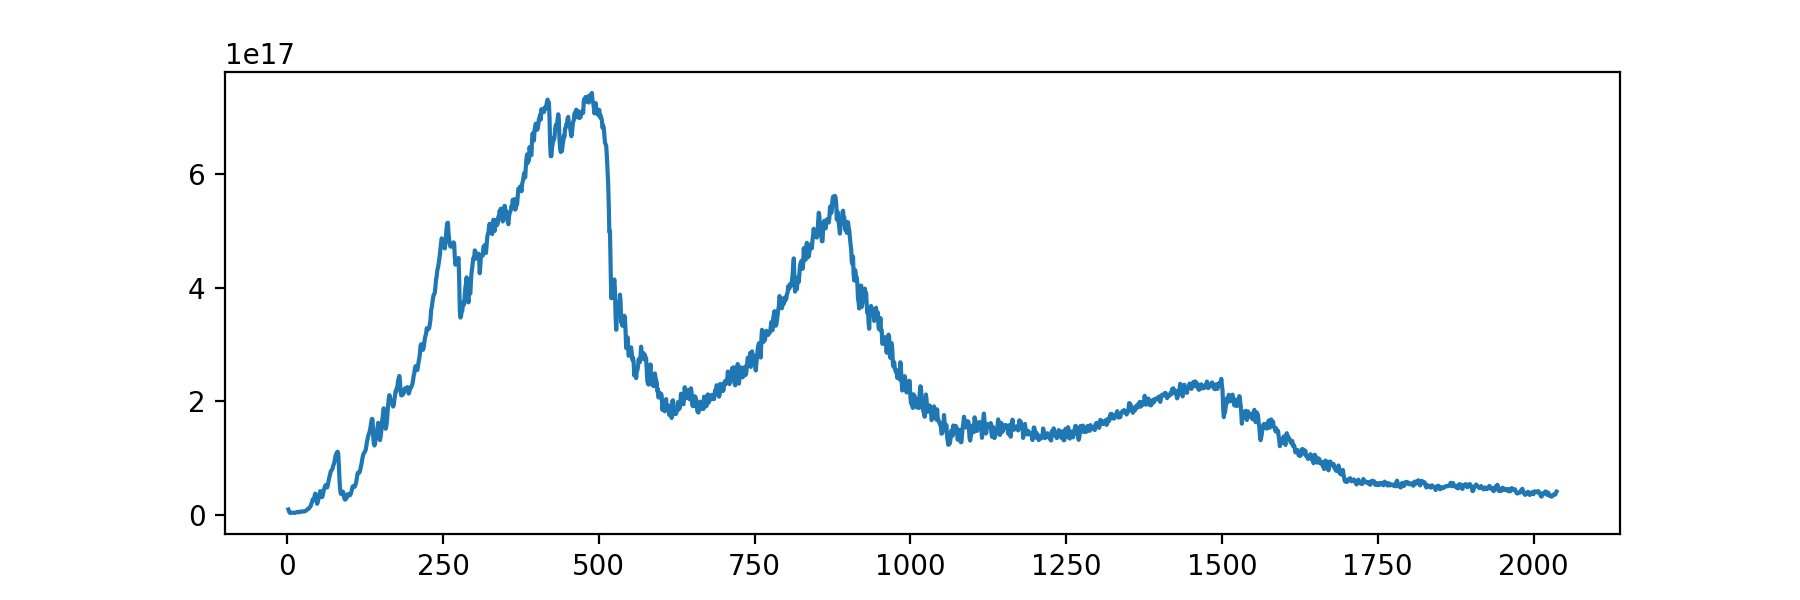

In [44]:
plt.plot(f_bin)

In [8]:
# Extract
grid = grid_from_map(wv_1, P1, n_os=1)
conv = np.array([0, 0, 1, 0, 0])

box_psf = box_psf.astype(float)
box_psf = box_psf / box_psf.sum(axis=0)
box_psf[np.isnan(box_psf)] = 0.0

# Don't use sigma for box extraction
# sig = np.sqrt(scidata + 20.**2)  # Map of expected noise

extra = TrpzOverlap([box_psf], [wv_1], scidata=scidata, lam_grid=grid,
                    thresh=1e-5, c_list=[conv], t_list=[fct_ones], orders=[1])
f_k = extra.extract()
_, f_bin = extra.bin_to_pixel(grid_pix=grid_box, f_k=f_k)

/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


<IPython.core.display.Javascript object>


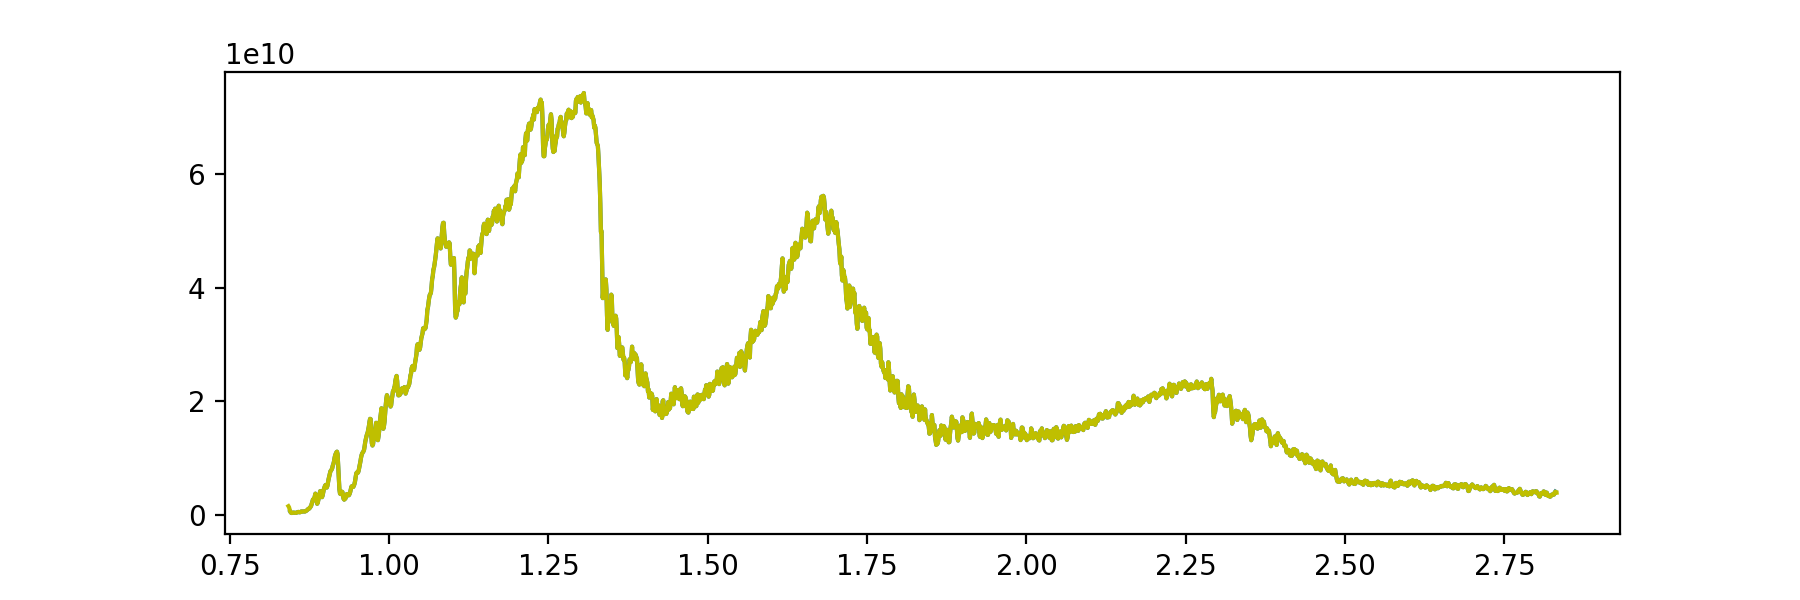

In [9]:
plt.plot(grid_box[:], f_bin[:])
plt.plot(grid_box, val_box, "y")

<IPython.core.display.Javascript object>


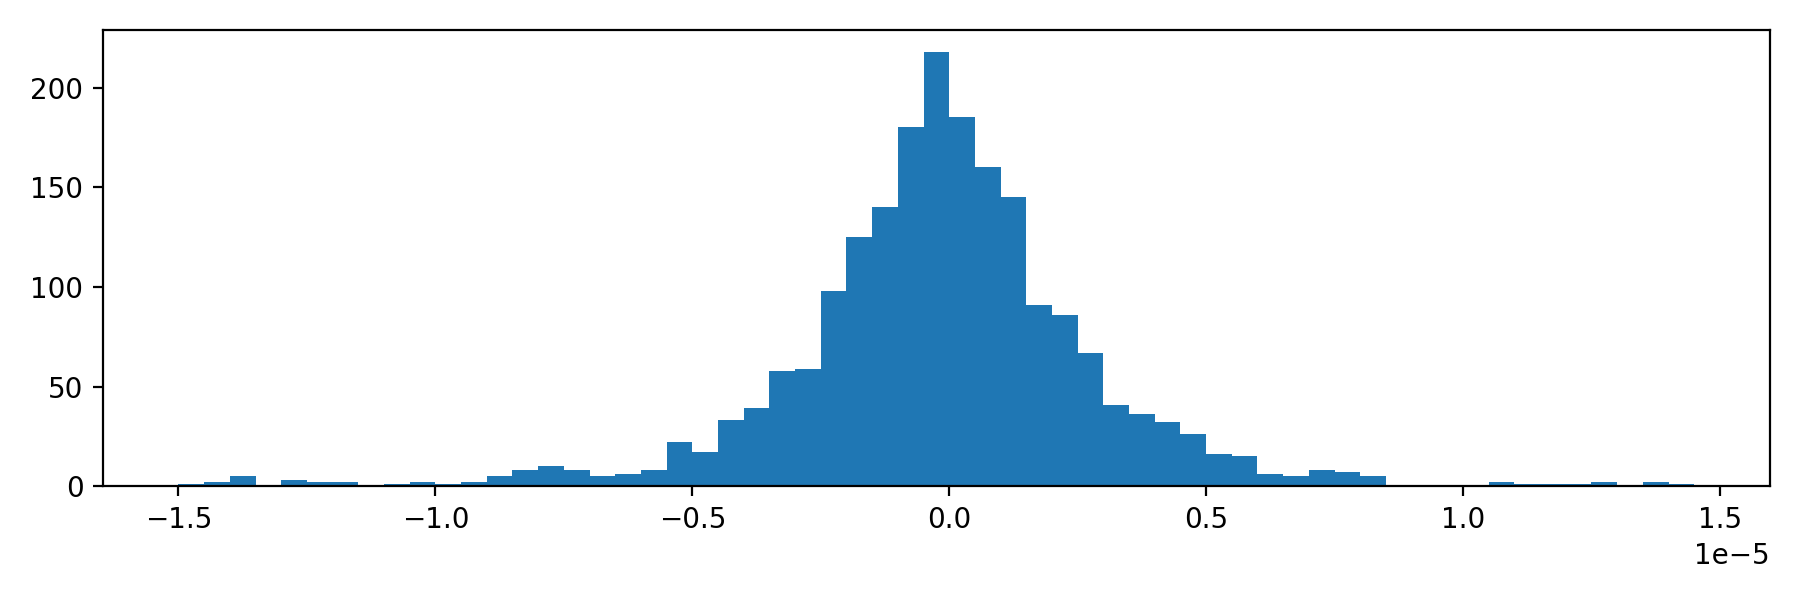

In [10]:
plt.hist((f_bin-val_box)/f_bin, bins=1e-5*np.arange(-1.5, 1.5, 0.05))
# plt.hist((f_bin-val_box)/f_bin, bins=1e-2*np.arange(-3.5, 3.5, 0.1))
plt.tight_layout()

# Test stability of both extraction

In [62]:
# Load a simulation
simu_clean = load_simu("../Simulations/phoenix_teff_02300_scale_1.0e+08_no-tilt.fits", order=1, noisy=False)

In [63]:
f_trpz_list = []
f_box_list = []

# Box
box_psf = (P1 > 1e-5)

# Trpz
# grid = grid_from_map(wv_1, P1, n_os=1)
# conv = np.array([0, 0, 1, 0, 0])
# box_psf_trpz = box_psf.astype(float)
# box_psf_trpz = box_psf_trpz / box_psf_trpz.sum(axis=0)
# box_psf_trpz[np.isnan(box_psf_trpz)] = 0.0

extra = TrpzBox(P1, wv_1)

for it in range(50):
    print(it, end="\r")
    
    scidata = add_noise(simu_clean["data"])
    
    f_k = extra.extract(data=scidata)
    
    if it == 0:
        lam_bin, f_box = box_extract(~box_psf, scidata, wv_1[50,:])
    else:
        _, f_box = box_extract(~box_psf, scidata, wv_1[50,:])
    
    _, f_trpz = extra.bin_to_pixel(f_k=f_k, grid_pix=lam_bin)
        
    f_box_list.append(f_box)
    f_trpz_list.append(f_trpz)
        


In [64]:
clean_data = simu_clean["data"]
sig = np.sqrt(clean_data + 20.**2)

/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


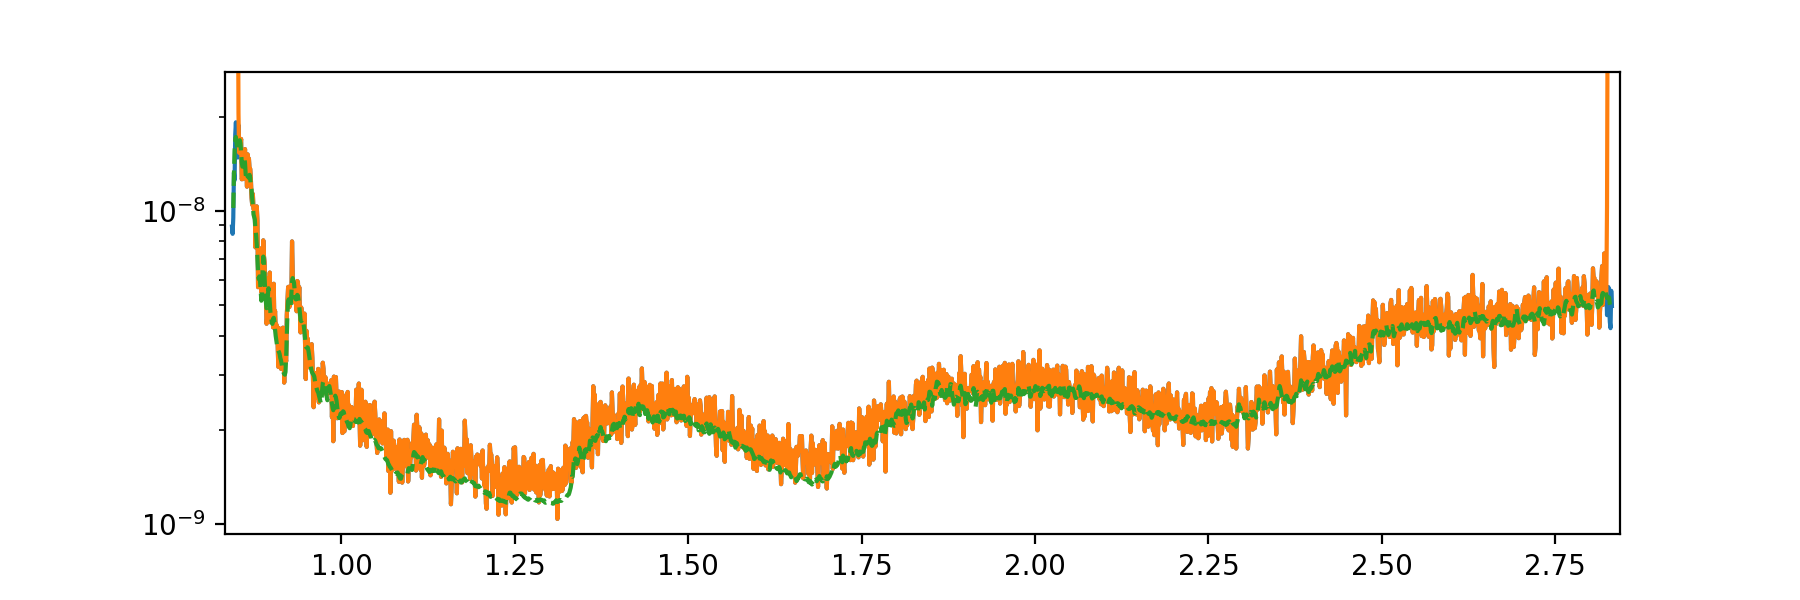

/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  


In [65]:
plt.semilogy(lam_bin, np.nanstd(f_box_list, axis=0)/np.nanmean(f_box_list, axis=0))
plt.semilogy(lam_bin, np.nanstd(f_trpz_list, axis=0)/np.nanmean(f_trpz_list, axis=0))
plt.semilogy(*extra.estim_noise(sig=sig, data=clean_data), "--")

<IPython.core.display.Javascript object>


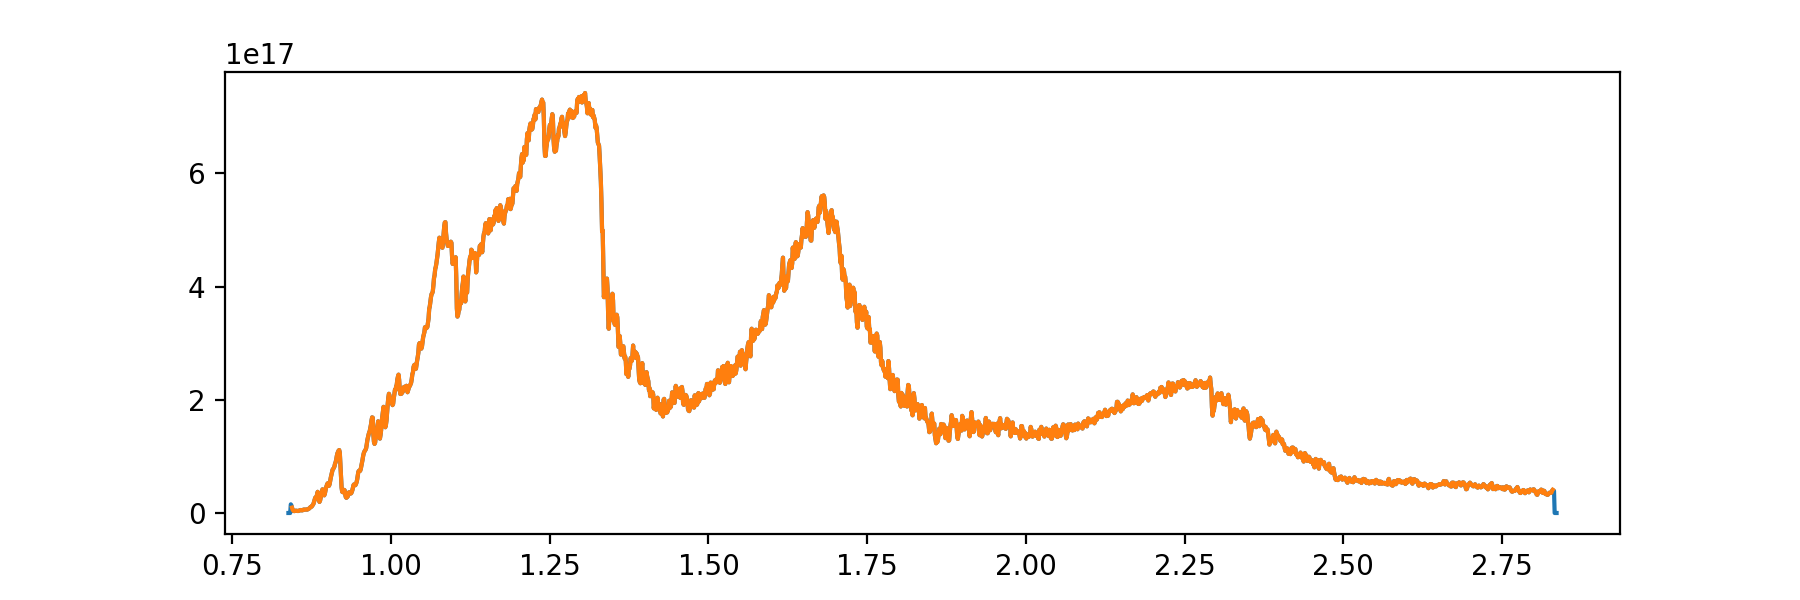

/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  


In [51]:
plt.plot(lam_bin, np.nanmean(f_box_list, axis=0))
plt.plot(lam_bin, np.nanmean(f_trpz_list, axis=0))